In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 0, 'redshift')

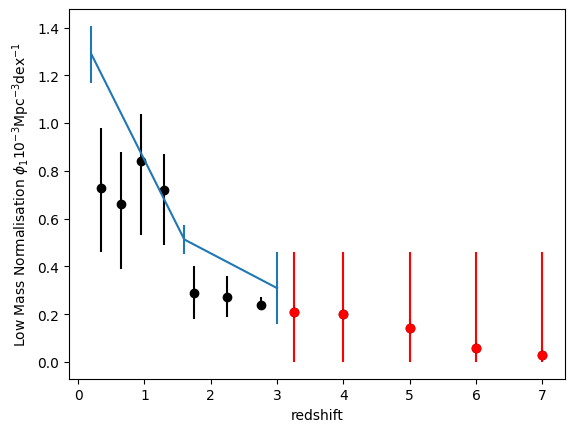

In [13]:
def propagate_cont_error(val, err):
    return abs(val)*abs(np.log(10)*err)

#assumption: declining normalisations with redshift
#little data above z>3, need to be open to having more galaxies at higher redshift due to results from jwst
#lhood or just use mean? if lhood, what width?? maybe just mean, assume small intrinsic scatter
#means are made up, problem?maybe using existing weaver points as mean...
#if have a gp for each, miss correlations between schecter parameters...

weaver_low_mass_norm_val = np.array([0.73, 0.66, 0.84, 0.72, 0.29, 0.27, 0.24, 0.21, 0.20, 0.14, 0.06, 0.03])
weaver_low_mass_norm_errl = np.array([0.27, 0.27, 0.31, 0.23, 0.11, 0.08, 0.02, 0.03, 0.03, 0.03, 0.02, 0.02])
weaver_low_mass_norm_errh = np.array([0.25, 0.22, 0.20, 0.15, 0.11, 0.09, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03])
weaver_redshift_lower_bin_edge = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5])
weaver_redshift_upper_bin_edge = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.5, 6.5, 7.5])
weaver_redshift_midpoint = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint, weaver_low_mass_norm_val, yerr=[weaver_low_mass_norm_errl, weaver_low_mass_norm_errh], fmt='ko')

log_cont_low_mass_norm_val = np.array([-2.89, -3.29, -3.51])
cont_low_mass_norm_val = (10**log_cont_low_mass_norm_val)*1000
cont_low_mass_norm_errl = (propagate_cont_error(cont_low_mass_norm_val, np.array([0.02, 0.02, 0.10]) + np.array([0.02, 0.03, 0.11])))
cont_low_mass_norm_errh = (propagate_cont_error(cont_low_mass_norm_val, np.array([0.02, 0.03, 0.11]) + np.array([0.02, 0.02, 0.10])))
cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

plt.errorbar(cont_redshift_anchor_points, cont_low_mass_norm_val, yerr=[cont_low_mass_norm_errl, cont_low_mass_norm_errh])

zg3_index = np.where(weaver_redshift_midpoint>3.0)[0]
zg3_redshifts = weaver_redshift_midpoint[zg3_index]
highz_low_mass_norm_val = weaver_low_mass_norm_val[zg3_index]
highz_low_mass_norm_errl = weaver_low_mass_norm_val[zg3_index]
high_zlow_mass_norm_errh = (cont_low_mass_norm_errh[-1] + cont_low_mass_norm_val[-1] - weaver_low_mass_norm_val[zg3_index])

plt.errorbar(zg3_redshifts, highz_low_mass_norm_val, yerr=[highz_low_mass_norm_errl, high_zlow_mass_norm_errh], fmt='ro')


plt.ylabel("Low Mass Normalisation $\phi_{1} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
plt.xlabel("redshift")

(-0.2, 7.2)

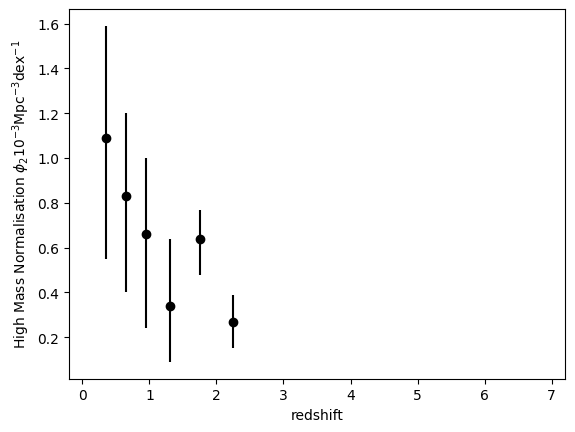

In [16]:
#it seems like weaver switiches to single shcecter function beyond z=3

weaver_high_mass_norm_val = np.array([1.09, 0.83, 0.66, 0.34, 0.64, 0.27])
weaver_high_mass_norm_errl = np.array([0.54, 0.43, 0.42, 0.25, 0.16, 0.12])
weaver_high_mass_norm_errh = np.array([0.5, 0.37, 0.34, 0.30, 0.13, 0.12])
weaver_redshift_lower_bin_edge_lowz = np.array([0.2, 0.5, 0.8, 1.1, 1.5, 2.0])
weaver_redshift_upper_bin_edge_lowz = np.array([0.5, 0.8, 1.1, 1.5, 2.0, 2.5])
weaver_redshift_midpoint_lowz = (weaver_redshift_lower_bin_edge + weaver_redshift_upper_bin_edge)/2
plt.errorbar(weaver_redshift_midpoint_lowz, weaver_high_mass_norm_val, yerr=[weaver_high_mass_norm_errl, weaver_high_mass_norm_errh], fmt='ko')

#log_cont_low_mass_norm_val = np.array([-2.44, -3.08, -4.14])
#cont_low_mass_norm_val = (10**log_cont_low_mass_norm_val)*1000
#cont_low_mass_norm_errl = (propagate_cont_error(cont_low_mass_norm_val, np.array([0.02, 0.02, 0.10]) + np.array([0.02, 0.03, 0.11])))
#cont_low_mass_norm_errh = (propagate_cont_error(cont_low_mass_norm_val, np.array([0.02, 0.03, 0.11]) + np.array([0.02, 0.02, 0.10])))
#cont_redshift_anchor_points = np.array([0.2, 1.6, 3.0])

#plt.errorbar(cont_redshift_anchor_points, cont_low_mass_norm_val, yerr=[cont_low_mass_norm_errl, cont_low_mass_norm_errh])

#zg3_index = np.where(weaver_redshift_midpoint>3.0)[0]
#zg3_redshifts = weaver_redshift_midpoint[zg3_index]
#highz_low_mass_norm_val = weaver_low_mass_norm_val[zg3_index]
#highz_low_mass_norm_errl = weaver_low_mass_norm_val[zg3_index]
#high_zlow_mass_norm_errh = (cont_low_mass_norm_errh[-1] + cont_low_mass_norm_val[-1] - weaver_low_mass_norm_val[zg3_index])

#plt.errorbar(zg3_redshifts, highz_low_mass_norm_val, yerr=[highz_low_mass_norm_errl, high_zlow_mass_norm_errh], fmt='ro')


plt.ylabel("High Mass Normalisation $\phi_{2} 10^{-3}\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}$")
plt.xlabel("redshift")
plt.xlim(-0.2, 7.2)

In [3]:
#apply gp to above, don't bother log, just clip.. or maybe log to get better behaviour close to zero, do I need that really?